## Importation of libraries

In [1]:
import urllib.request
import json
import pandas as pd
import numpy as np
from PIL import Image, ExifTags
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.linear_model import Perceptron
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

<br>

## Getting a Json with Wikidata Query
We created a WikiData Query to request a Json file, containing the links to open-licensed images. We used images with different themes:<br>

fruit = Q1364<br>
Dog = Q144<br>
lake  = Q23397<br>


SELECT ?image ?im WHERE {
  ?image wdt:P31 wd:Q506.
  ?image wdt:P18 ?im
  }
LIMIT 200

In [ ]:
lstSources = {"Fruit":1364,"Dog":144,"Lake":23397} #Sources from which we download the images
limitPerSources = 5
sources = {}
tagTemp = []
for key,value in lstSources.items():    #Get all images to download
    url ="https://query.wikidata.org/sparql?query=SELECT%20%3Fimage%20%3Fim%20WHERE%20%7B%0A%20%20%3Fimage%20wdt%3AP31%20wd%3AQ"+str(value)+".%0A%20%20%3Fimage%20wdt%3AP18%20%3Fim%0A%20%20%7D%0ALIMIT%20"+str(limitPerSources)+"&format=json"
    response = urllib.request.urlopen(url)
    myJson = json.loads(response.read().decode("utf-8"))
    
    for image in myJson["results"]["bindings"]:  #Add the tag to the image
        image['tag'] = key
        
    if sources == {}:   #Make one big json containing all images information
        sources = myJson
    else:
        sources["results"]["bindings"] = sources["results"]["bindings"]+myJson["results"]["bindings"]

myJsonNormalized = pd.json_normalize(sources)
print(myJson)

<br>

## Télechargement des images ##
A partir du Json contenant les liens menant aux images, nous lancons des requètes URLLIB pour télecharger ces images.

In [20]:
# Downloading images

responseJson = myJsonNormalized["results.bindings"]
index=0
lstTag=[]
for i in range(len(responseJson[0])):   
    # Getting image Link for each image
    imageLink = responseJson[0][i]["im"]["value"]
    lstTag.append(responseJson[0][i]["tag"])
    
    # Requesting to Download images and saving it as "images$.jpg" where $ is the image id
    im = "./images/image"+str(index)+".jpg"
    urllib.request.urlretrieve(imageLink, im)
    index +=1

    #Convert images to RGB, to prevent future errors
    try:
        imgfile = Image.open(im).convert("RGB")
    except:
        index-=1
        del lstTag[-1]
        print("pas fonctionne")
    
NOMBRE_IMAGE=index

c:\Users\augus\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:3011: DecompressionBombWarning: Image size (95300352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


<br>

## Récupération des métadonnées
L'obhectif de cette partie est de récupérer les informations des images, nous récupérons les images suivantes :<br>
1. Récupération Exif utiles
2. Récupération couleurs dominantes (K-means)
3. Récupération taille des images
4. Détermination portrait ou paysage

Apres cela, nous avons creer un Json **metaDataJson.json** contenant toutes les informationns precedentes

In [ ]:
# Collecting meta-data

metaData ={}
for i in range(NOMBRE_IMAGE):
    im = "./images/image"+str(i)+".jpg"
    try:
        imgfile = Image.open(im).convert("RGB")

        # selecting the useful Exif
        exif = {}
        exifCritere= ("Model","Make","ImageDescription","ExposureTime","GPSInfo","ISO","DateTimeOriginal")
        for k,v in  imgfile.getexif().items() :
            if k in ExifTags.TAGS :
                if ExifTags.TAGS[k] in exifCritere:
                    exif = {ExifTags.TAGS[k]:v}

        # Collecting 3 predominant colors (using K-means)
        numarray = np.array(imgfile.getdata(), np.uint8)
        clusters  = MiniBatchKMeans(n_clusters=3, n_init=2) 
        clusters.fit(numarray)
        L = clusters.cluster_centers_.astype(int).tolist()

        # Really simply setting the dominant color using the value of the most present color in the image
        if L[0][0]>L[0][1] and L[0][0]>L[0][2]:
            domColor = "Red"
        elif L[0][1]>L[0][0] and L[0][1]>L[0][2]:
            domColor = "Green"
        elif L[0][2]>L[0][0] and L[0][2]>L[0][1]:
            domColor = "Blue"
        elif L[0][0]==L[0][1]==L[0][2]:
            domColor = "White"
        else:
            domColor = "None"

        # Collecting images sizez
        width = imgfile.width
        height = imgfile.height
        mode = imgfile.mode

        # identify image orientation
        if abs(1-width/height)<0.1 :
            orientation='carre' 
        elif width>height:
            orientation='paysage'
        else: 
            orientation="portrait"

        # Get image size (big, small, ...)
        pixelCount = width * height

        if pixelCount >= 1920*1080:
            size = "Grande"
        elif pixelCount >= 1280*720:
            size = "Moyenne"
        elif pixelCount >= 720*480:
            size = "Petite"
        elif pixelCount < 720*480:
            size = "Vignette"
        else:
            size = "WTF"

        metaData["image"+str(i)] = { "width" : width, "height": height, "exif": exif, "mode":mode, "tags":[lstTag[i]], "couleurs":L, "orientation":orientation, "size":size, "dom":domColor}
    except Exception:
        print("l'image "+str(i) +" ne peut pas etre ouverte")
metaData

metaDatajson = json.dumps(metaData)
f = open("metaDataJson.json", "w")
f.write(metaDatajson)
f.close()



c:\Users\augus\AppData\Local\Programs\Python\Python39\lib\site-packages\PIL\Image.py:3011: DecompressionBombWarning: Image size (95300352 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


## Data Analysis
Consist of 2 parts :
1. The first one  color analysis to get if an image has a colors patern close to mages previously liked image by the user. Then we feed it to a more global analysis.
2. The global analysis, use a decision tree classifier to analyse the data in our user database, and the result of our color analyses, and predict if an image is likely to be liked by the user.


In [6]:
def flatten(L):
# INPUT     : L (List)
# OUTPUT    : Flattened version of L
# DESCRIPTION : return a flattened version of the input list "L" : [[1,2,3],[1,2]] -> [1,2,3,1,2]
    return [item for sublist in L for item in sublist]




def analyseCouleur(nameUser,nomImage): 
# INPUT     : numUser (user ID as an integer ex:1)
#           : nomImage (the name in metadatajson.json of the image to predictas a string ex:"image0")
# OUTPUT    : y_predict[0] (an integer either 0 if the algorithm precict the user won't like the image
#             or 1 if the image is predicted to be liked)
# DESCRIPTION : predict if an user will liked an image, based solely on the image color mathing previous images


    couleurs = []
    jsonUserDF=pd.read_json("jsonUser.json")
    jsonMetaDF=pd.read_json("metaDataJson.json")
    #userId="user"+str(numUser)

    for image in jsonUserDF[nameUser]["images"]:
        couleurs.append(flatten(jsonMetaDF[image]["couleurs"]))
        
    # creating training the model with what the user have already seen
    numarray=np.array(couleurs)
    like=np.array(jsonUserDF[nameUser]["result"])
  
    percep = Perceptron(max_iter=1000)
    percep.fit(numarray, like)


    # predicting if the use would like the input image
    x_predict = np.array([flatten(jsonMetaDF[nomImage]["couleurs"])])
    y_predict = percep.predict(x_predict)

    return y_predict[0]

# exemple to test the function by itself:
# analyseCouleur("user1","image1")

In [ ]:

def analyseGlobal(nameUser,nomImage):
    # INPUT     : nameUser (string), nomImage (string)
    # OUTPUT    : prediction
    # DESCRIPTION : returns whether the user should or shouldn't like the image ("Favorite" or "NotFavorite")

    # Get image data
    jsonMetaDF = pd.read_json("metaDataJson.json")

    # Get user like
    userDF = pd.read_json("jsonUser.json")
    userImages = userDF.loc["images"][nameUser]
    userLike = userDF.loc["result"][nameUser]

    # Get data from the images already seen by the user for the training
    data = []
    for item in userImages:
        imageDesc = []
        imageDesc.append(jsonMetaDF.loc["dom"][item])
        imageDesc.append(jsonMetaDF.loc["tags"][item][0])
        imageDesc.append(jsonMetaDF.loc["size"][item])
        imageDesc.append(jsonMetaDF.loc["orientation"][item])
        imageDesc.append(analyseCouleur(nameUser,item))
        data.append(imageDesc)

    # Get whether the user liked or not the images for the training
    result = [None]*len(userImages)
    for item in jsonMetaDF:
        if item in userImages:
            ind = userImages.index(item)
            if userLike[ind] == 1:
                result[ind]="Favorite"
            else :
                result[ind]="NotFavorite"

    # creating dataframes
    dataframe = pd.DataFrame(data, columns=["dom", "tags", "size", "orientation","likedColor"])
    resultframe = pd.DataFrame(result, columns=["favorite"])

    le1 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    dataframe["dom"] = le1.fit_transform(dataframe["dom"].values.reshape(-1,1))

    le2 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    dataframe["tags"] = le2.fit_transform(dataframe["tags"].values.reshape(-1,1))

    le3 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    dataframe["size"] = le3.fit_transform(dataframe["size"].values.reshape(-1,1))

    le4 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    dataframe["orientation"] = le4.fit_transform(dataframe["orientation"].values.reshape(-1,1))

    le5 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    dataframe["likedColor"] = le5.fit_transform(dataframe["likedColor"].values.reshape(-1,1))

    le6 = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    resultframe["favorite"] = le6.fit_transform(resultframe["favorite"].values.reshape(-1,1))
    
    # Use of decision tree classifiers
    dtc = tree.DecisionTreeClassifier()
    dtc = dtc.fit(dataframe.values, resultframe)


    #prediction

    # Get data from the image we want to predict
    colorP = jsonMetaDF.loc["dom"][nomImage]
    tagsP = jsonMetaDF.loc["tags"][nomImage]
    sizeP = jsonMetaDF.loc["size"][nomImage]
    orientationP = jsonMetaDF.loc["orientation"][nomImage]
    colorLikeP = analyseCouleur(nameUser,nomImage)
    
    prediction = dtc.predict(np.array([
        
            le1.transform(pd.DataFrame([colorP], columns=["couleur"]))[0],
            le2.transform(pd.DataFrame([tagsP], columns=["tag"]))[0],
            le3.transform(pd.DataFrame([sizeP], columns=["size"]))[0],
            le4.transform(pd.DataFrame([orientationP], columns=["orientation"]))[0],
            le5.transform(pd.DataFrame([colorLikeP], columns=["likedColor"]))[0],
        
    ]).reshape(1,-1))
    
    #print(dtc.feature_importances_)
    return le6.inverse_transform(prediction.reshape(-1,1)).tolist()[0][0]
    
#TODO Vérifier que likedColor pas toujours le seul critère déterminant
analyseGlobal("user4","image8")


## Systeme de recommendation

In [ ]:
def createUser(nom, prenom, images = None,like = None):
# INPUT     : nom (User first name as a string)
#           : prenom (User last name as a string)
#           : images (OPTIONAL, a list of all images the user have already seen, ex:[image1,image2])
#           : prenom (OPTIONAL, a list of 0 and 1, which corresponds to images, ex:[0,1] meaning the user only like the second image)
# DESCRIPTION : Dcreate a new user in our user database (jsonUser.json), using name, last name, and already seen images as input


    jsonUser=json.load(open("jsonUser.json"))
    userId="user"+str(len(jsonUser))

    # If optional arguments,like and images are not presented, set them at random
    if images == None:
        firstImage = "image" + str(random.randint(0,NOMBRE_IMAGE-1))
        images = [firstImage]
        like = [random.randint(0,1)]
    
    # Creating the json structure
    if len(images) == len(like) :
        jsonUser[userId]={"nom" : nom,"prenom" : prenom, "images":images,"result":like,"year":"","size":"","tagFav":"","orientation":"","couleursFav":""}
    else :
        print("Please give image and like list of same size")
    
    # Storing the structure in our database (jsonUser.json)
    jsonUserStr = json.dumps(jsonUser, indent=4)
    f = open("jsonUser.json", "w")
    f.write(jsonUserStr)
    f.close()  
createUser("Jean", "Paul")


In [ ]:
def demandeFavoriteOrNot(nomImage,typeEnjoyer="UserLikeImages"):
# INPUT     : nomImage (the name in metadatajson.json of the image to predictas a string ex:"image0")
#           : typeEnjoyer (OPTIONAL, it is a test parameter to tell the machine to like every image with a specific tag)
# OUTPUT    : 0(int) or 1(int) (0 means the user disliked the image, 1 the user liked)
# DESCRIPTION : Provide the image to the user and asked if the user like it. If thhe Optional argument typeEnjoyer
#             : is provided, it automatically fill the likes depending of the parameter value.


    jsonMetaDF = pd.read_json("metaDataJson.json")

    # TypeEnjoyer not provided (manual function) 
    if typeEnjoyer =="UserLikeImages":
        image = Image.open("images/"+nomImage+'.jpg')
        image.show()
        while True:
            a = input("Do you like that picture ? Please press 1 (YES) or 0 (NO)")
            if a in ('0','1'):
                b = input("Please enter the most adequate tag (0 = default tag)")
                break
             
        return [int(a), b] 
    
    # TypeEnjoyer provided (test function) 
    elif typeEnjoyer =="dogEnjoyer":
        return [int("Dog" in jsonMetaDF[nomImage]["tags"]),'0']
    elif typeEnjoyer =='fruitEnjoyer':
        return [int("Fruit" in jsonMetaDF[nomImage]["tags"]),'0']
    elif typeEnjoyer =='lakeEnjoyer':
        return [int("Lake" in jsonMetaDF[nomImage]["tags"]),'0']







def cyclePropositionImage(userName,typeEnjoyer="UserLikeImages"):
    # INPUT     : numUser (user ID as an integer ex:1)
    #           : typeEnjoyer (OPTIONAL, it is a test parameter to tell the machine to like every image with a specific tag)
    # DESCRIPTION : Predict which image the user will like, provide it to the use and fill in our user database that the user 
    # have now seen the image, and if he/she/{} liked it.

    
    
    jsonMetaDF = pd.read_json("metaDataJson.json")
    jsonUserDF=pd.read_json("jsonUser.json")

    imageDonee=[]
    imagePasDonnes=[]
    imageAdonne=1

    # extract the images, the user have not seen yet
    jsonMetaKeys=jsonMetaDF.keys()
    random.shuffle(jsonMetaKeys.tolist())
    for image in jsonMetaKeys:
        if image not in jsonUserDF[userName]["images"]:
            ana=analyseGlobal(userName,image)
            if ana==('Favorite'):
                imageDonee.append(image)
                break
            else:
                imagePasDonnes.append(image)

    # show the user a random image which the model predict to be liked
    if imageDonee!=[]:
        imageAdonne=random.choice(imageDonee)
        jsonUserDF[userName]["images"].append(imageAdonne)

    # or another one if the images are all inadequate
    elif imagePasDonnes!=[]:
        imageAdonne=random.choice(imagePasDonnes)
        jsonUserDF[userName]["images"].append(imageAdonne)

    else :
        print("All images have been shown to " + userName)
        return "All images have been shown"
    #print(imageAdonne)
    res = demandeFavoriteOrNot(imageAdonne,typeEnjoyer)
    if res[1] !='0' :
        if res[1] in lstTag:
            jsonUserDF[userId]["tagsFav"]=res[1]
        else:
            print( "error : tag not in list, previous tag kept instead")

    jsonUserDF[userId]["result"].append(res[0])
    
    
    jsonUserDF.to_json("jsonUser.json",orient='columns',indent=4)               


def testNcycle(N):
    for i in range(N):
        cyclePropositionImage("user0", "dogEnjoyer")
        cyclePropositionImage("user1","dogEnjoyer")
        cyclePropositionImage("user2","fruitEnjoyer")
        cyclePropositionImage("user3","lakeEnjoyer")
testNcycle(7)





## Update user preferences

In [ ]:
user = "user0" #Select user

def userPreferences(userName = None):

     # INPUT     : userName (string)
     # OUTPUT    : None
     # DESCRIPTION : Sets the user preferences in jsonUser.json. Happens for all user if no argument is given
     
     # Get ima
     jsonMetaDF = pd.read_json("metaDataJson.json")

     # Get user like
     userDF = pd.read_json("jsonUser.json")

     # Sets the user list, for which the preferences will be updated
     userlst = []
     if userName == None:
          for user in userDF:
               userlst.append(user)
     else:
          userlst.append(user)

     # Gets all images seen and liked by the user
     for user in userlst:
          userImages = userDF.loc["images"][user]
          userLike = userDF.loc["result"][user]
          likedImages = []
          for item in userImages :
               ind = userImages.index(item)
               if userLike[ind] == 1:
                    likedImages.append(item)

          # Gets all liked images' data
          if len(likedImages) > 0:
               ori = []
               siz = []
               tagF = []
               colorF = []
               for image in likedImages :
                    ori.append(jsonMetaDF.loc["orientation"][image])
                    siz.append(jsonMetaDF.loc["size"][image])
                    tagF.append(jsonMetaDF.loc["tags"][image])
                    colorF.append(jsonMetaDF.loc["dom"][image])

               # Gets the data most present in the user's liked images and sets them as his preferences
               jsonUser=json.load(open("jsonUser.json"))
               jsonUser[user]["orientation"]=max(ori,key = ori.count)
               jsonUser[user]["size"]=max(siz,key = siz.count)
               jsonUser[user]["tagFav"]=max(tagF,key = tagF.count)
               jsonUser[user]["colorFav"]=max(colorF,key = colorF.count)
               
               jsonUserStr = json.dumps(jsonUser, indent=4)
               f = open("jsonUser.json", "w")
               f.write(jsonUserStr)
               f.close()  

userPreferences() # Updates all user preferences

## Show User Preferences

In [ ]:
def printUserPref(userName = None):
    # INPUT     : userName (string)
    # OUTPUT    : The user's preferences
    # DESCRIPTION : Shows the selected user or all user's preferences is no argument is given

    if userName == None:
        userDF = pd.read_json("jsonUser.json")
    else :
        userDF = pd.read_json("jsonUser.json")
        userDF = userDF[userName]
    return userDF["orientation":"colorFav"]

printUserPref() # Show all user preferences

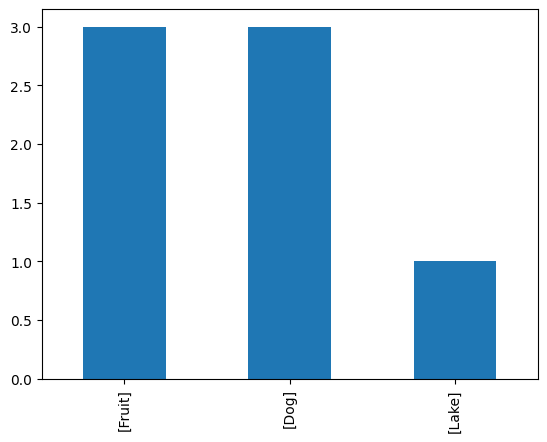

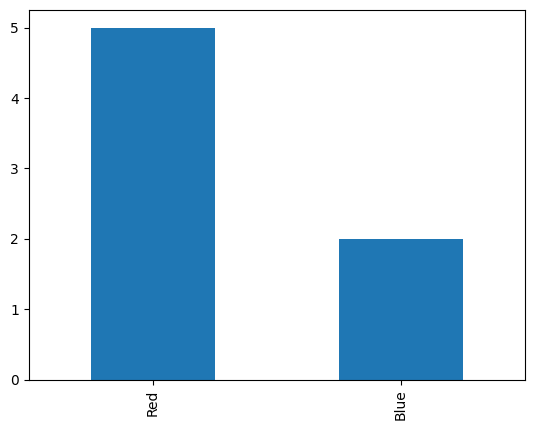

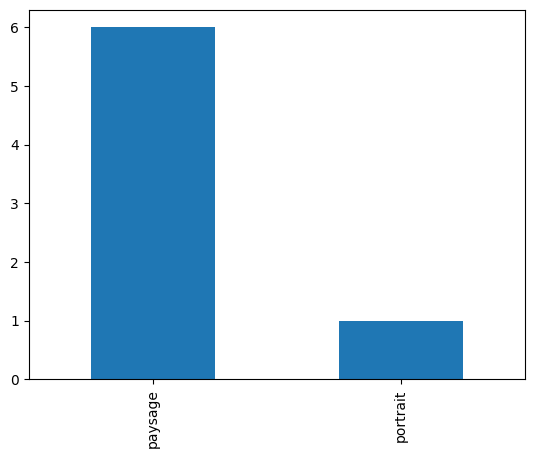

In [16]:
# Plot user liked images' stats : tags, size, ...
def plotPref(plotLst = ["tags","dom","orientation","size"],userName = None):
    # INPUT     : plotLst (lst), userName (string)
    # OUTPUT    : None
    # DESCRIPTION : Plots a specific user's like image data or plots all the data from the images in the databases.

    userDF = pd.read_json("jsonUser.json")
    jsonMetaDF = pd.read_json("metaDataJson.json")

    toPlotCount = []
    if type(plotLst) != list:
        plotLst = [plotLst]
    
    if userName == None :
        for stat in plotLst :
            if stat in ["tags","dom","orientation","size"]:     # Stats that can be plotted are in this list
                toPlot = []
                for image in jsonMetaDF :
                    toPlot.append(jsonMetaDF.loc[stat][image])
                    
                toPlotCount.append(pd.Series(toPlot).value_counts())

    if userName != None and userName in userDF:
        userImages = userDF.loc["images"][userName]
        userLike = userDF.loc["result"][userName]
        likedImages = []
        for item in userImages :
           ind = userImages.index(item)
           if userLike[ind] == 1:
                likedImages.append(item)
        for stat in plotLst :
            if stat in ["tags","dom","orientation","size"]:     # Stats that can be plotted are in this list
                toPlot = []
                for image in likedImages :
                    toPlot.append(jsonMetaDF.loc[stat][image])
                toPlotCount.append(pd.Series(toPlot).value_counts())
        
    for plotCount in toPlotCount:
        fig = plt.figure()
        plotCount.plot.bar()
    plt.show()

plotPref(["tags","dom","orientation"],"user0")